## Libraries

In [1]:
#Importing Libraries

import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import random
import pandas as pd
import numpy as np

#Ignoring depriciated warnings for test purposes
import warnings
warnings.filterwarnings('ignore')

## Reading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
from tensorflow.contrib import lite
converter = lite.TFLiteConverter.from_keras_model_file('drive/MyDrive/FYP/UrduAssistantModel.h5')
tfmodel = converter.convert()
open ("drive/MyDrive/FYP/UrduAssistantLiteModel.tflite" , "wb") .write(tfmodel)

ModuleNotFoundError: ignored

In [ ]:
#Reading Dataset information from csv
dataInfo = pd.read_csv('drive/MyDrive/FYP/DATA.csv')

#Displaying Dataset
print(dataInfo) 

                                                   Data  Label
0     drive/MyDrive/FYP/Data/P22/Airplane mode chala...      3
1     drive/MyDrive/FYP/Data/P22/Airplane mode laga ...      3
2     drive/MyDrive/FYP/Data/P22/Airplane mode lagao...      3
3     drive/MyDrive/FYP/Data/P22/Airplane mode off k...      4
4     drive/MyDrive/FYP/Data/P22/Airplane mode on ka...      3
...                                                 ...    ...
5389         drive/MyDrive/FYP/Data/P12/wifi chalao.m4a     21
5390       drive/MyDrive/FYP/Data/P12/youtube kholo.m4a     25
5391               drive/MyDrive/FYP/Data/P12/zarab.m4a     16
5392              drive/MyDrive/FYP/Data/P12/zarbay.m4a     16
5393     drive/MyDrive/FYP/Data/P12/aaj kia din hai.m4a     31

[5394 rows x 2 columns]


In [ ]:
#Function to read Dataset
def readData_Librosa(dataInfo):
    
    #List for Storing all the data
    Dataset = []
    
    #Reading all audio files and their respective labels
    for index, path in enumerate(dataInfo['Data']): 
        
        try:
            audioData, audioSample_rate = librosa.load(path)
            label = dataInfo['Label'][index]
            Dataset.append((audioData, audioSample_rate, label))
            
        except:
            print("Couldn't Find: ", path)
            None
        

    return Dataset


#Reading data
Dataset = readData_Librosa(dataInfo)

Couldn't Find:  drive/MyDrive/FYP/Data/P22/Airplane mode lagao.ogg
Couldn't Find:  drive/MyDrive/FYP/Data/P22/Airplane mode on karo.ogg
Couldn't Find:  drive/MyDrive/FYP/Data/P22/Awaz band kardo.ogg
Couldn't Find:  drive/MyDrive/FYP/Data/P22/Brightness kam karo.ogg
Couldn't Find:  drive/MyDrive/FYP/Data/P22/Ek.ogg
Couldn't Find:  drive/MyDrive/FYP/Data/P22/Jamma.ogg
Couldn't Find:  drive/MyDrive/FYP/Data/P22/Mobile data chalao.ogg
Couldn't Find:  drive/MyDrive/FYP/Data/P22/Panch.ogg


In [ ]:
#Storing dataset pickle to reload dataset later
import pickle


def saveDataset(Dataset):
    
    dbfile = open('drive/MyDrive/FYP/Dataset', 'wb')

    # source, destination
    pickle.dump(Dataset, dbfile)                     
    dbfile.close()

saveDataset(Dataset)

KeyboardInterrupt: ignored

In [ ]:
import pickle

def loadDataset():
    
    #Reloading dataset
    dbfile = open('drive/MyDrive/FYP/Dataset', 'rb')     
    db = pickle.load(dbfile)
    dbfile.close()
    
    return db

Dataset = loadDataset()

In [ ]:
Dataset[100]

(array([ 1.47951098e-07, -1.32854822e-07,  1.07175644e-07, ...,
         4.20048041e-03,  4.24322532e-03,  6.29323721e-03], dtype=float32),
 22050,
 36)

In [ ]:
NewDataSet = []

for labelIndex in range(0, len(Dataset)):

  if(Dataset[labelIndex][2] == 21 or Dataset[labelIndex][2] == 22 or Dataset[labelIndex][2] == 20 or Dataset[labelIndex][2] == 19):
    NewDataSet.append(Dataset[labelIndex])
  elif(Dataset[labelIndex][2] == 9 or Dataset[labelIndex][2] == 10 or Dataset[labelIndex][2] == 3 or Dataset[labelIndex][2] == 4):
    NewDataSet.append(Dataset[labelIndex])
  else:
    temp = []
    temp.append(Dataset[labelIndex][0])
    temp.append(Dataset[labelIndex][1])
    temp.append(0)
    NewDataSet.append(temp)
  

In [ ]:
NewDataSet[100]

[array([ 1.47951098e-07, -1.32854822e-07,  1.07175644e-07, ...,
         4.20048041e-03,  4.24322532e-03,  6.29323721e-03], dtype=float32),
 22050,
 0]

## Data Visualization

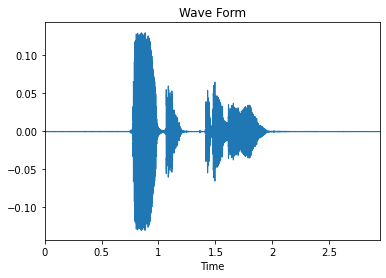

In [ ]:
#Testing a sample voice data
testIndex = random.randint(0, len(NewDataSet)-1)

#Waveform
plt.title("Wave Form")
librosa.display.waveplot(NewDataSet[testIndex][0], sr=NewDataSet[testIndex][1])
plt.show()

In [ ]:
#Audio
ipd.Audio(data=NewDataSet[testIndex][0], rate=NewDataSet[testIndex][1])

In [ ]:
#Label
print("Label:", NewDataSet[testIndex][2])

#Total Data
print("Total Data:", len(NewDataSet), "files")

Label: 0
Total Data: 3970 files


## Preprocessing

In [ ]:
#Function to read Background noises 
def readBackgrounds_Librosa(Path):
    
    #List for Storing all the data
    Backgrounds = []
    
    #To fetch total Items in Path Directory
    backgroundSounds = os.listdir(Path)
    
    #Reading all background sounds
    for index, sound in enumerate(backgroundSounds): 
        
        try:
            audioData, audioSample_rate = librosa.load(str(Path+sound))
            Backgrounds.append((audioData, audioSample_rate))
            
        except:
            None
        

    return Backgrounds

#Fetching background sounds
Backgrounds = readBackgrounds_Librosa("drive/MyDrive/FYP/Data/Background/")
print("Total Background Sounds:", len(Backgrounds))

Total Background Sounds: 9


In [ ]:
#Function to add background noises to the actual sounds to populate dataset
def generateNewData(Dataset, Backgrounds):
    
    audios = []
    sampleRates = []
    labels = []

    #Looping through all dataset points and background points to merge them
    for index1  in range(0, len(Dataset)): 
            #for index2  in range(0, len(Backgrounds)): 
                
                #try:
                    tempAudio1, tempSample_rate1 = Dataset[index1][0], Dataset[index1][1]
                    #backLen = Backgrounds[index2][0].shape[0]
                    #randomBack = random.randint(0,backLen)
                    #tempAudio2, tempSample_rate2 = Backgrounds[index2][0][randomBack:tempAudio1.shape[0]+randomBack], Backgrounds[index2][1]
                    
                    #newSound = (tempAudio1+tempAudio2)/2
                    #newRate = int((tempSample_rate1))

                    audios.append(tempAudio1)
                    sampleRates.append(tempSample_rate1)
                    labels.append(Dataset[index1][2])

                    #audios.append(newSound)
                    #sampleRates.append(newRate)
                    #labels.append(Dataset[index1][2])

                #except:
                    #continue

    return audios, sampleRates, labels

#Generating newly populated dataset
audios, sampleRates, labels = generateNewData(NewDataSet, Backgrounds)

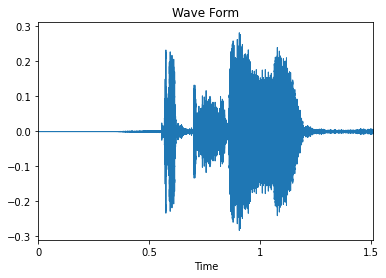

In [ ]:
#Testing newly populated dataset
testIndex = random.randint(0, len(audios)-1)

#Waveform
plt.title("Wave Form")
librosa.display.waveplot(audios[testIndex], sr=sampleRates[testIndex])
plt.show()

In [ ]:
#Audio
ipd.Audio(data=audios[testIndex], rate=sampleRates[testIndex])

In [ ]:
#Label
print("Label:", labels[testIndex])

#Total new files
print("Total Data:", len(audios), "files")

Label: 0
Total Data: 3970 files


#Model Training

### Feature Extraction

In [ ]:
def librosa_features_extractor(audios, sampleRates, labels):

    extracted_features = []
  
    for index, audio in enumerate(audios):
      mfccs_features = librosa.feature.mfcc(y=audio, sr=sampleRates[index], n_mfcc=40)
      mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

      extracted_features.append([mfccs_scaled_features, labels[index]])
    
    return extracted_features


extracted_features = librosa_features_extractor(audios, sampleRates, labels)

In [ ]:
extracted_features_dataframe = pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_dataframe.head(10)

,feature,class
0,"[-315.5749, 148.65614, 0.7266535, 19.16985, -6...",3
1,"[-309.9757, 158.96935, 3.3695061, 22.751308, -...",3
2,"[-327.74133, 145.1631, 11.577982, 21.809309, -...",3
3,"[-322.92468, 155.3476, -1.7861578, 15.238972, ...",4
4,"[-313.12775, 158.32935, 5.1661596, 20.172152, ...",3
5,"[-318.1584, 148.05798, 13.69596, 25.101727, 6....",0
6,"[-315.8757, 135.43126, 3.0094986, 17.744858, -...",0
7,"[-340.6168, 148.81679, -5.0899224, 11.038908, ...",0
8,"[-334.41187, 151.24074, 6.495757, 10.681529, -...",0
9,"[-311.87585, 141.21974, 2.96489, 14.417709, -2...",0


In [ ]:
#Storing extracted_features_dataframe pickle to reload it later
import pickle

def saveExtractedFeatures(extracted_features_dataframe):
    
    dbfile = open('drive/MyDrive/FYP/extracted_features_dataframe', 'wb')

    # source, destination
    pickle.dump(extracted_features_dataframe, dbfile)                     
    dbfile.close()

saveExtractedFeatures(extracted_features_dataframe)

In [ ]:
import pickle

def loadExtractedFeatures():
    
    #Reloading dataset
    dbfile = open('drive/MyDrive/FYP/extracted_features_dataframe', 'rb')     
    db = pickle.load(dbfile)
    dbfile.close()
    
    return db

extracted_features_dataframe = loadExtractedFeatures()

### Model

In [ ]:
X = np.array(extracted_features_dataframe['feature'].tolist())
y = np.array(extracted_features_dataframe['class'].tolist())

In [ ]:
counts = extracted_features_dataframe['class'].nunique()
print(counts)

9


In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [ ]:
from sklearn.model_selection import train_test_split

# create train, validation, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1)

# add an axis to nd array
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers, models
from tensorflow.keras import backend as K

In [ ]:
EPOCHS = 200
BATCH_SIZE = 16
PATIENCE = 5
LEARNING_RATE = 0.0001
loss="categorical_crossentropy"

input_shape = (X_train.shape[1], X_train.shape[2], 1)
num_labels = 9

In [ ]:
# build network architecture using convolutional layers
model = tf.keras.models.Sequential()

# 1st conv layer
model.add(tf.keras.layers.Conv2D(256, (2,2), activation='relu', padding='same',input_shape =  input_shape))
model.add(tf.keras.layers.BatchNormalization())

# 2nd conv layer
model.add(tf.keras.layers.Conv2D(128, (2,2), activation='relu', padding='same'))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))

# 2nd conv layer
model.add(tf.keras.layers.Conv2D(128, (2,2), activation='relu', padding='same'))

# 3rd conv layer
model.add(tf.keras.layers.Conv2D(64, (2,2), activation='relu', padding='same'))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))

# 4th conv layer
model.add(tf.keras.layers.Conv2D(64, (2,2), activation='relu', padding='same'))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.MaxPooling2D((3, 3), padding='same'))

# 5th conv layer
model.add(tf.keras.layers.Conv2D(32, (2,2), activation='relu', padding='same'))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.MaxPooling2D((3, 3), padding='same'))

# flatten output and feed into 3 dense layers
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(128, activation='relu'))

model.add(tf.keras.layers.Dense(64, activation='relu'))


# softmax output layer
model.add(tf.keras.layers.Dense(num_labels, activation='softmax'))

optimiser = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

# compile model
model.compile(optimizer=optimiser,loss=loss,metrics=["accuracy"])

# print model parameters on console
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 40, 1, 256)        1280      
                                                                 
 batch_normalization_4 (Batc  (None, 40, 1, 256)       1024      
 hNormalization)                                                 
                                                                 
 conv2d_19 (Conv2D)          (None, 40, 1, 128)        131200    
                                                                 
 conv2d_20 (Conv2D)          (None, 40, 1, 128)        65664     
                                                                 
 conv2d_21 (Conv2D)          (None, 40, 1, 64)         32832     
                                                                 
 conv2d_22 (Conv2D)          (None, 40, 1, 64)         16448     
                                                      

In [ ]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.0001, patience=PATIENCE)

In [ ]:
history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])

Epoch 1/200
 75/201 [==========>...................] - ETA: 1s - loss: 0.9562 - accuracy: 0.7700

KeyboardInterrupt: ignored

In [ ]:
model.save('drive/MyDrive/FYP/UrduAssistantModel.h5')

In [ ]:
new_model = tf.keras.models.load_model('drive/MyDrive/FYP/UrduAssistantModel.h5')

In [ ]:
train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print("Train Accuracy:", train_accuracy[1])

Train Accuracy: 0.9400511980056763


In [ ]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", test_accuracy[1])

Test Accuracy: 0.8925288319587708


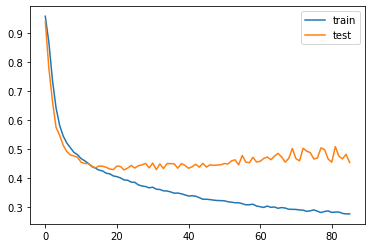

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Testing

In [ ]:
filename="drive/MyDrive/FYP/Data/P21/Screenshot lo.ogg"
audio, sample_rate = librosa.load(filename) 

###
tempAudio1, tempSample_rate1 = audio, sample_rate
tempAudio2, tempSample_rate2 = Backgrounds[5][0][:tempAudio1.shape[0]], Backgrounds[2][1]             
newSound = (tempAudio1+tempAudio2)/2
newRate = int((tempSample_rate1))
###

mfccs_features = librosa.feature.mfcc(y=newSound, sr=newRate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

#print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
#print(mfccs_scaled_features)
#print(mfccs_scaled_features.shape)
predicted_label=model.predict(mfccs_scaled_features)
#print(predicted_label)
classes_x=np.argmax(predicted_label,axis=1)
prediction_class = labelencoder.inverse_transform(classes_x)
prediction_class

ValueError: ignored